In [1]:
import numpy as np
from itertools import combinations
import pandas as pd
import igraph as ig

from queue import PriorityQueue

#from igraph.drawing.colors import GradientPalette#ColorScale, ColorBrewer
#import ColorBrewer

import random
from bike_functions import *

In [2]:
def reader_function(city):
    # Trips
    path_trips = 'Data/' + city + '_trips.tntp'
    with open(path_trips, 'r') as f:
        data = f.readlines()

    table = []
    for line in data:
        if 'Origin' in line:
            origin = line.strip().split()[1]
        else:
            for destination in line.strip().split(';')[:-1]:
                destination_number, weight = destination.split(':')
                table.append([origin, destination_number.strip(), weight.strip()])

    trips = pd.DataFrame(table, columns=['Origin', 'Destination', 'Weight'])

    # Nodes

    net_path = "Data/" + city + "_net.tntp"
    net = pd.read_csv(net_path, skiprows=8, sep='\t').drop(["~",";"], axis=1)

    # Flow

    flow_path = "Data/" + city + "_flow.tntp"
    flow = pd.read_csv(flow_path, sep='\t|\s', engine='python')
    net = net.merge(flow[["Volume"]], left_index=True, right_index=True)

    return net, flow, trips


Load trips data as potential commuter data
+ Anaheim

In [3]:
anaheim, anaheim_flow, anaheim_trips = reader_function('Anaheim')
anaheim_trips.head()

,Origin,Destination,Weight
0,1,2,1365.90
1,1,3,407.40
2,1,4,861.40
3,1,5,354.40
4,1,6,545.10


In [4]:
anaheim

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,Volume
0,1,117,9000,5280,1.090458,0.15,4,4842,0,1,7074.9
1,2,87,9000,5280,1.090458,0.15,4,4842,0,1,9662.5
2,3,74,9000,5280,1.090458,0.15,4,4842,0,1,7669.0
3,4,233,9000,5280,1.090458,0.15,4,4842,0,1,12173.8
4,5,165,9000,5280,1.090458,0.15,4,4842,0,1,2586.8
...,...,...,...,...,...,...,...,...,...,...,...
909,414,405,5400,5280,2.000000,0.15,4,2640,0,1,619.8
910,415,22,5400,2640,1.000000,0.15,4,2640,0,1,934.2
911,415,406,5400,5280,2.000000,0.15,4,2640,0,1,904.6
912,416,23,5400,2640,1.000000,0.15,4,2640,0,1,387.9


+ Sioux Falls

In [5]:
sf, sf_flow, sf_trips  = reader_function("SiouxFalls")

In [6]:
sf_trips

,Origin,Destination,Weight
0,1,1,0.0
1,1,2,100.0
2,1,3,100.0
3,1,4,500.0
4,1,5,200.0
...,...,...,...
571,24,20,400.0
572,24,21,500.0
573,24,22,1100.0
574,24,23,700.0


# Graphing the networks:

## Anaheim

IGRAPH DN-- 416 914 -- 
+ attr: color (v), degree (v), name (v), shape (v), Volume (e), b (e), capacity (e), color (e), free_flow_time (e), length (e), link_type (e), power (e), speed (e), toll (e)


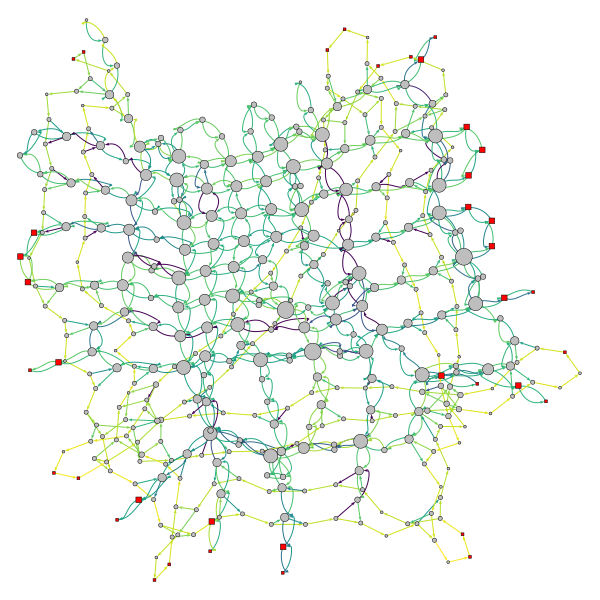

In [7]:
# %% convert the dataframe data to a graph.
g = ig.Graph.TupleList(anaheim.itertuples(index=False), directed=True, weights=False, edge_attrs=["capacity","length","free_flow_time","b","power","speed","toll","link_type", "Volume"])

# add colour as edge attribute - on the basis of volume
g.es['color'] = continuous_to_rgb(np.log(anaheim.Volume +1)).tolist()

# give zone-nodes a different colour and shape to make them visible

zone_indices = list(range(1,39))

colors = ["red" if i in zone_indices else "grey" for i in range(g.vcount())]
shapes = ["square" if i in zone_indices else "circle" for i in range(g.vcount())]
g.vs["color"] = colors
g.vs["shape"] = shapes

# add degree as vertex attribute
degree = g.degree()
g.vs["degree"] = degree

# calculate vertex sizes based on degree

sizes = [d * 1.4 for d in degree]

#adjust layout -  for full list of options: https://igraph.org/python/tutorial/0.9.6/visualisation.html#graph-layouts
layout = g.layout("kamada_kawai") # most suitable: kamada_kawai __ DrL __fruchterman_reingold __ davidson_harel

# get graph information and plot
print(g.summary()) # 416 vertices and 914 edges
ig.plot(g, vertex_size = sizes, layout=layout, edge_arrow_size = 0.3, vertex_frame_width=0.5)


## Sioux Falls

IGRAPH DN-- 24 76 -- 
+ attr: degree (v), name (v), Volume (e), b (e), capacity (e), color (e), free_flow_time (e), length (e), link_type (e), power (e), speed (e), toll (e)


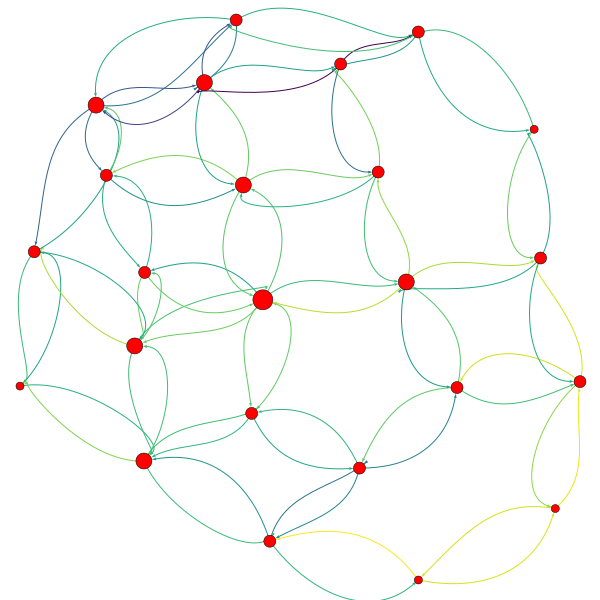

In [8]:
# %% convert the dataframe data to a graph.
gsf = ig.Graph.TupleList(sf.itertuples(index=False), directed=True, weights=False, edge_attrs=["capacity","length","free_flow_time","b","power","speed","toll","link_type", "Volume"])

# add colour as edge attribute - on the basis of volume
gsf.es['color'] = continuous_to_rgb(np.log(anaheim.Volume +1)).tolist()

# add degree as vertex attribute
degree = gsf.degree()
gsf.vs["degree"] = degree

# calculate vertex sizes based on degree

sizessf = [d * 2 for d in degree]

#adjust layout -  for full list of options: https://igraph.org/python/tutorial/0.9.6/visualisation.html#graph-layouts
layoutsf = gsf.layout("kamada_kawai") # most suitable: kamada_kawai __ DrL __fruchterman_reingold __ davidson_harel

# get graph information and plot
print(gsf.summary()) # 416 vertices and 914 edges
ig.plot(gsf, vertex_size = sizessf, layout=layoutsf, edge_arrow_size = 0.3, vertex_frame_width=0.5)


In [9]:
gsf_df = gsf.get_edge_dataframe()

# Optimal Station Placement

Because of the different sizes of the networks, we will attempt to apply optimal station placement over a subgraph of the Anaheim graph, and on the whole graph for the case of Sioux Falls. 

### Sioux Falls

In [10]:
sf_trips["Origin"].astype(int).max()


24

In [11]:
# find all shortest paths between vertices in the subset

zones_sf = list(range(1,24))
shortest_paths = []
for source in zones_sf:
    for target in zones_sf:
        if source != target:
            paths = gsf.get_all_shortest_paths(source, to=target, weights="free_flow_time")
            shortest_paths.extend(paths)

#print(shortest_paths) # list of lists
trip_paths = pd.DataFrame({
    'path': shortest_paths,
    'Origin': [lst[0] for lst in shortest_paths],
    'Destination': [lst[-1] for lst in shortest_paths],
    'path_length': [len(lst) for lst in shortest_paths]
})

print(trip_paths[0:10])
print(trip_paths.shape)


#count the number of duplicates
num_duplicates = trip_paths.duplicated(subset=['Origin', 'Destination']).sum()
print(f"There are {num_duplicates} duplicates in the DataFrame, as multiple candidates for the shortest path exist between many nodes.")

grouped = trip_paths.groupby(['Origin', 'Destination']).size().reset_index(name='count')
grouped_filtered = grouped[grouped['count'] > 1]

print(grouped_filtered)

## for simplicity, I now simply randomly select one potential shortest path betwen each zone-node
## we could later try to attach likelihoods of any of them being used based on the volume along each of the paths

trip_paths_simple = trip_paths.groupby(['Origin', 'Destination']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)
print(trip_paths_simple.head())
print(trip_paths_simple.shape) 

# check that there are no more duplicate
#num_duplicates = trip_paths_simple.duplicated(subset=['Origin', 'Destination']).sum()
#num_duplicates


                path  Origin  Destination  path_length
0          [1, 0, 2]       1            2            3
1             [1, 3]       1            3            2
2       [1, 3, 6, 4]       1            4            4
3       [1, 0, 2, 5]       1            5            4
4          [1, 3, 6]       1            6            3
5    [1, 3, 6, 4, 7]       1            7            5
6       [1, 3, 6, 8]       1            8            4
7          [1, 3, 9]       1            9            3
8      [1, 3, 9, 10]       1           10            4
9  [1, 3, 9, 10, 11]       1           11            5
(534, 4)
There are 28 duplicates in the DataFrame, as multiple candidates for the shortest path exist between many nodes.
     Origin  Destination  count
27        2            7      2
34        2           14      3
36        2           16      2
61        3           19      2
85        4           21      2
100       5           14      2
106       5           20      2
133       7      

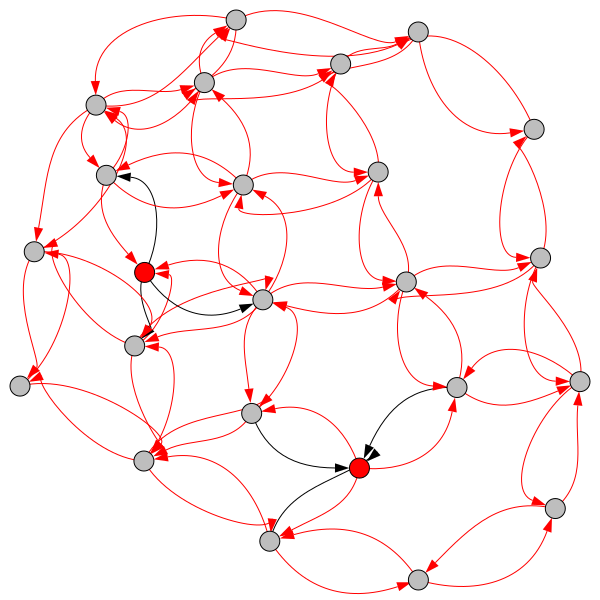

In [12]:
# %% Generate fake station data:
bike_stations = random.sample(gsf.vs.indices,2)
station_paths = gsf.get_all_simple_paths(bike_stations[0], bike_stations[1])

station_paths.append(gsf.get_all_simple_paths(bike_stations[1], bike_stations[0]))

is_bike_edge = paths_to_edges(station_paths, gsf_df)

# visualize and plot

gsf.es['color'] = ['red' if edge else 'black' for edge in is_bike_edge]

colors = ["red" if i in bike_stations else "grey" for i in range(gsf.vcount())]
gsf.vs["color"] = colors

ig.plot(gsf)

In [13]:
# We merge trips data and simple paths

sf_trips = sf_trips.astype({"Origin":"int","Destination":"int", "Weight":"float"})
sf_trips = sf_trips.astype({"Weight":"int"})

riders = pd.merge(sf_trips, trip_paths_simple, on=['Origin', 'Destination'])
# g_df = g.get_edge_dataframe()

riders["travel_time"]= riders['path'].apply(calculate_travel_time_ff, args=(gsf_df,))

# because we are using the subgraph, there will be travel times == 0 (not in the subplot)
# we filter them out. when using the whole graph, the data is fully computed
# riders = real_riders_merged[real_riders_merged["travel_time"]!=0]
riders["travel_time_weighted"]=riders["travel_time"]*riders["Weight"]

In [14]:
 # %% calculate new travel time based on this
travel_time_bike = []
for i, path in enumerate(riders.path):
    if any_subpath(station_paths, path):
        travel_time_bike.append(calculate_travel_time_bike_ff(path, gsf_df, is_bike_edge)*riders["Weight"].iloc[i])
    else:
        travel_time_bike.append(riders['travel_time_weighted'].iloc[i])
riders['travel_time_bike'] = pd.Series(travel_time_bike)


print('travel time without stations: ', riders.travel_time_weighted.sum())
print('travel time with two randomly placed stations: ', riders.travel_time_bike.sum())


travel time without stations:  4801900
travel time with two randomly placed stations:  4786300.0


We see that by placing two random stations there is a significant decrease in global travel time. Now let's see the time reduction when we iterate over all possible stations and find the best possible pair.

In [15]:

stations = filter_stations(list(combinations(gsf.vs.indices,2)))

station_time = []
for station in stations:
    station_paths = gsf.get_all_simple_paths(station[0], station[1])
    station_paths.append(gsf.get_all_simple_paths(station[1], station[0]))

    is_bike_edge = paths_to_edges(station_paths, gsf_df)

    travel_time_bike = []
    for i, path in enumerate(riders.path):
        if any_subpath(station_paths, path):
            travel_time_bike.append(calculate_travel_time_bike_ff(path, gsf_df, is_bike_edge)*riders["Weight"].iloc[i])
        else:
            travel_time_bike.append(riders.iloc[i]['travel_time_weighted'])
    riders['travel_time_bike'] = pd.Series(travel_time_bike)
    station_time.append(riders.travel_time_bike.sum())



In [20]:
# report of stations and their times:
station_df = pd.DataFrame({"station":stations, "station_time":station_time})
station_df


,station,station_time
0,"(0, 1)",4789500.0
1,"(0, 2)",4794600.0
2,"(0, 3)",4801900.0
3,"(0, 4)",4801900.0
4,"(0, 5)",4795600.0
...,...,...
271,"(20, 22)",4777050.0
272,"(20, 23)",4753700.0
273,"(21, 22)",4768900.0
274,"(21, 23)",4733300.0


In [21]:
station_df.to_csv("station_df method I.csv")

<Axes: >

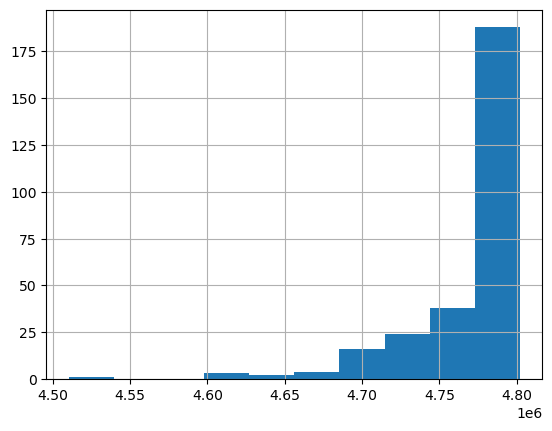

In [22]:
# this is a visualization of travel time iterating over all possible stations.
# we see most bike station placements result in little time reduction, while there are a few outliers
# that reduce time a lot
station_df.station_time.hist()



In [23]:
# top 10 station placements and their times
station_df.sort_values('station_time').head(10)


,station,station_time
185,"(10, 11)",4510500.0
244,"(15, 20)",4603500.0
212,"(12, 15)",4615450.0
236,"(14, 20)",4622150.0
255,"(17, 18)",4642150.0
198,"(11, 12)",4652650.0
217,"(12, 20)",4673350.0
231,"(14, 15)",4674200.0
208,"(11, 22)",4674400.0
186,"(10, 12)",4684900.0


best bike station placement:


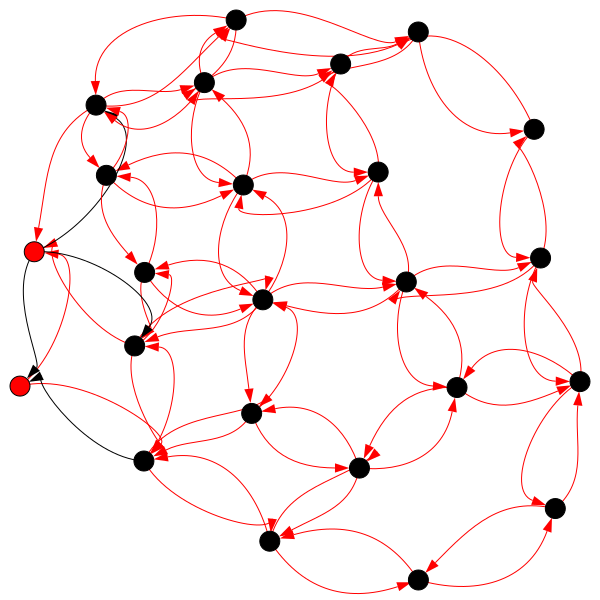

In [24]:
# %% visualization of best station
station = station_df.sort_values('station_time').head(1).station.values[0]
station_paths = gsf.get_all_simple_paths(station[0], station[1])
station_paths.append(gsf.get_all_simple_paths(station[1], station[0]))

is_bike_edge = paths_to_edges(station_paths, gsf_df)

# visualize and plot
gsf.es['color'] = ['red' if edge else 'black' for edge in is_bike_edge]
gsf.vs['color'] = ['red' if node in station else 'black' for node in gsf.vs.indices]
print('best bike station placement:')
ig.plot(gsf)

### Describing the best stations

We calculate some centrality measures for all nodes.

In [96]:
# Calculate the out-degree centrality
out_degrees = gsf.outdegree()
max_out_degree = max(out_degrees)
out_degree_centrality = [degree/max_out_degree for degree in out_degrees]

# Calculate the in-degree centrality
in_degrees = gsf.indegree()
max_in_degree = max(in_degrees)
in_degree_centrality = [degree/max_in_degree for degree in in_degrees]

# Calculate the betweenness centrality
betweenness_centrality = gsf.betweenness()

# Calculate the eigenvector centrality
eigenvector_centrality = gsf.eigenvector_centrality(directed=True)

# Calculate the closeness centrality
closeness_centrality = gsf.closeness()

# Calculate the degree centrality of each node
degree = gsf.degree()
max_degree = gsf.vcount() - 1
degree = [centrality / max_degree for centrality in degree]



In [97]:
centrality = pd.DataFrame([betweenness_centrality, out_degree_centrality, in_degree_centrality, eigenvector_centrality, closeness_centrality, degree]).T.rename(columns={0:'betweenness',1:'out_degree', 2:'in_degree', 3:'eigenvector', 4:'closeness', 5:'degree'})
centrality.head()



,betweenness,out_degree,in_degree,eigenvector,closeness,degree
0,17.833333,0.4,0.4,0.089937,0.264368,0.173913
1,18.619048,0.4,0.4,0.108197,0.267442,0.173913
2,48.214286,0.6,0.6,0.204656,0.306667,0.260870
3,49.419048,0.6,0.6,0.286435,0.310811,0.260870
4,51.023810,0.6,0.6,0.334040,0.348485,0.260870


In [98]:
station1 = []
station2 = []
for station in station_df.station:
    station1.append(station[0])
    station2.append(station[1])

station_df['station1'] = station1
station_df['station2'] = station2

In [99]:
station_centrality = station_df.merge(centrality, how='left', left_on='station1', right_index=True).merge(centrality, how='left', left_on='station2', right_index=True,  suffixes=("_o", "_d"))
station_centrality['int_in_degree_centrality'] = station_centrality.in_degree_o * station_centrality.in_degree_d
station_centrality['int_out_degree_centrality'] = station_centrality.out_degree_o * station_centrality.out_degree_d

In [100]:
og_time = 4801900
station_centrality['pct_change']  = (station_centrality.station_time - og_time)/og_time

In [107]:
station_centrality.to_csv("station_df method I.csv")

In [102]:
import statsmodels.api as sm
station_centrality.columns

Index(['station', 'station_time', 'station1', 'station2', 'betweenness_o',
       'out_degree_o', 'in_degree_o', 'eigenvector_o', 'closeness_o',
       'degree_o', 'betweenness_d', 'out_degree_d', 'in_degree_d',
       'eigenvector_d', 'closeness_d', 'degree_d', 'int_in_degree_centrality',
       'int_out_degree_centrality', 'pct_change'],
      dtype='object')

In [105]:
station_centrality = sm.add_constant(station_centrality)

big_model = sm.OLS(station_centrality['pct_change'], station_centrality[['const', 'betweenness_o',
       'out_degree_o', 'in_degree_o', 'eigenvector_o', 'closeness_o',
       'degree_o', 'betweenness_d', 'out_degree_d', 'in_degree_d',
       'eigenvector_d', 'closeness_d', 'degree_d', 'int_in_degree_centrality',
       'int_out_degree_centrality']]).fit()

In [106]:
big_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     5.401
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           8.40e-07
Time:                        16:31:08   Log-Likelihood:                 958.67
No. Observations:                 276   AIC:                            -1897.
Df Residuals:                     266   BIC:                            -1861.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0022      0.020     -0.110      0.913      -0.041       0.037
betweenness_o              8.365e-06   4.37e-05      0.191      0.848   -7.77e-05    9.45e-05
out_degree_o                  0.0159      0.008      1.926      0.055      -0.000       0.032
in_degree_o                   0.0159      0.008      1.926      0.055      -0.000       0.032
eigenvector_o                -0.0278      0.006     -4.402      0.000      -0.040      -0.015
closeness_o                   0.0266      0.033      0.812      0.418      -0.038       0.091
degree_o                      0.0069      0.004      1.926      0.055      -0.000       0.014
betweenness_d              4.548e-05   5.23e-05      0.869      0.385   -5.75e-05       0.000
out_degree_d                  0.0042      0.008      0.506      0.613      -0.012       0.021
in_degree_d                   0.0042      0.008      0.506      0.613      -0.012       0.021
eigenvector_d                 0.0056      0.009      0.651      0.516      -0.011       0.022
closeness_d                  -0.0881      0.043     -2.066      0.040      -0.172      -0.004
degree_d                      0.0018      0.004      0.506      0.613      -0.005       0.009
int_in_degree_centrality     -0.0058      0.011     -0.518      0.605      -0.028       0.016
int_out_degree_centrality    -0.0058      0.011     -0.518      0.605      -0.028       0.016
==============================================================================
Omnibus:                      155.173   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1007.101
Skew:                          -2.256   Prob(JB):                    2.05e-219
Kurtosis:                      11.199   Cond. No.                     2.26e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.71e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Describing best 4 and worst 4 station placements

In [108]:
low_4 = np.argsort(station_centrality.station_time)[0:4].values
top_4 = np.argsort(station_centrality.station_time)[-4:]

In [109]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# create four color sets
node_colors1 = ['red' if node in station_centrality.loc[top_4].iloc[0].station else 'blue' for node in gsf.vs.indices]
node_colors2 = ['red' if node in station_centrality.loc[top_4].iloc[1].station else 'blue' for node in gsf.vs.indices]
node_colors3 = ['red' if node in station_centrality.loc[top_4].iloc[2].station else 'blue' for node in gsf.vs.indices]
node_colors4 = ['red' if node in station_centrality.loc[top_4].iloc[3].station else 'blue' for node in gsf.vs.indices]

# gsf.vs['color'] = ['red' if node in station else 'black' for node in gsf.vs.indices]


best bike station placement:


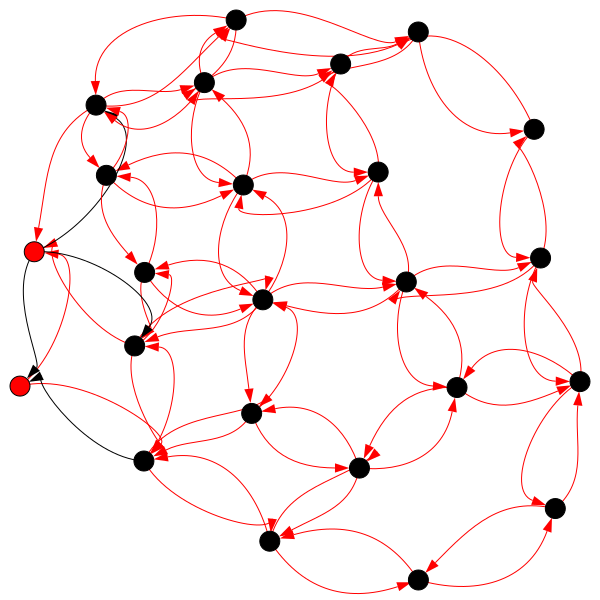

In [110]:
# %% visualization of best station
station = station_df.sort_values('station_time').head(1).station.values[0]
station_paths = gsf.get_all_simple_paths(station[0], station[1])
station_paths.append(gsf.get_all_simple_paths(station[1], station[0]))

is_bike_edge = paths_to_edges(station_paths, gsf_df)

# visualize and plot
gsf.es['color'] = ['red' if edge else 'black' for edge in is_bike_edge]
gsf.vs['color'] = ['red' if node in station else 'black' for node in gsf.vs.indices]
print('best bike station placement:')
ig.plot(gsf)

In [111]:
g_nx = nx.Graph(gsf.to_networkx())
g_nx.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23))

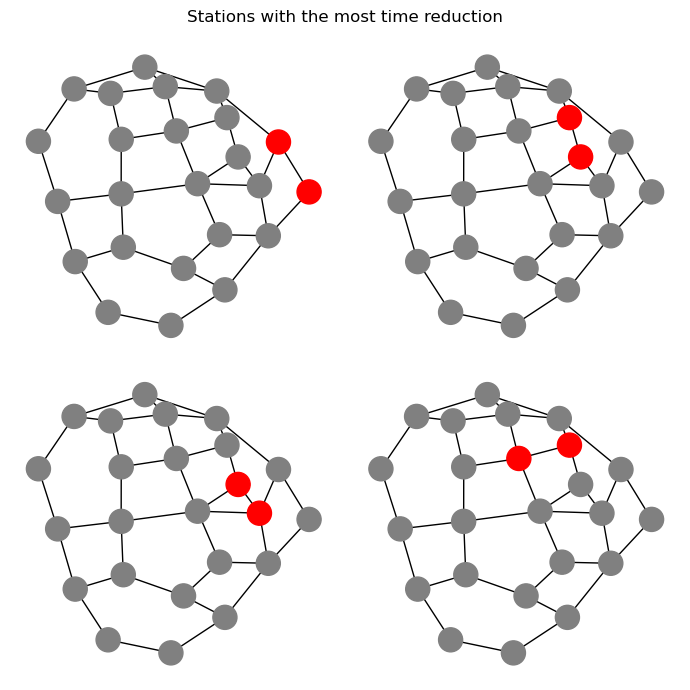

In [112]:
# create four color sets
node_colors1 = ['red' if node in station_centrality.loc[low_4].iloc[0].station else 'grey' for node in g_nx.nodes()]
node_colors2 = ['red' if node in station_centrality.loc[low_4].iloc[1].station else 'grey' for node in g_nx.nodes()]
node_colors3 = ['red' if node in station_centrality.loc[low_4].iloc[2].station else 'grey' for node in g_nx.nodes()]
node_colors4 = ['red' if node in station_centrality.loc[low_4].iloc[3].station else 'grey' for node in g_nx.nodes()]

# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.spring_layout(g_nx)


# plot each graph in a different subplot
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[0, 0], node_color=node_colors1)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[0, 1], node_color=node_colors2)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[1, 0], node_color=node_colors3)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[1, 1], node_color=node_colors4)

# set plot title and axis labels
fig.suptitle('Stations with the most time reduction')


plt.tight_layout()
plt.show()

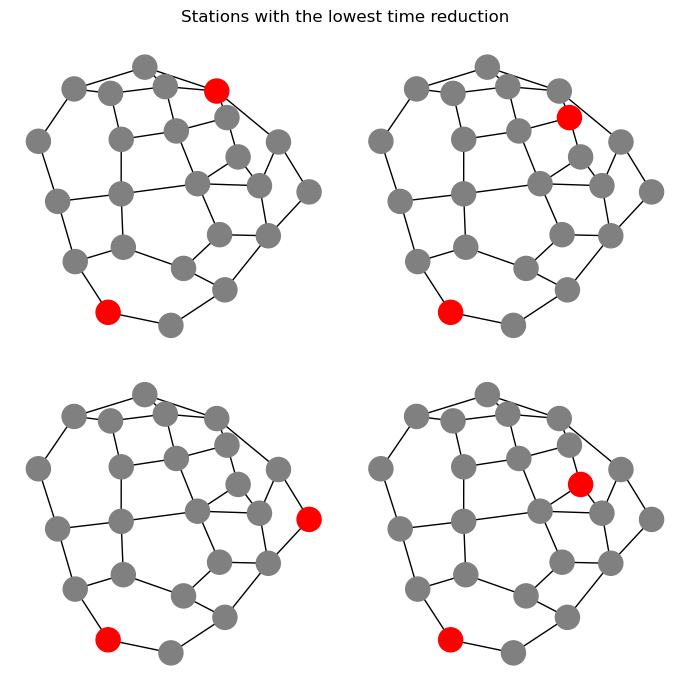

In [113]:
# create four color sets
node_colors1 = ['red' if node in station_centrality.loc[top_4].iloc[0].station else 'grey' for node in g_nx.nodes()]
node_colors2 = ['red' if node in station_centrality.loc[top_4].iloc[1].station else 'grey' for node in g_nx.nodes()]
node_colors3 = ['red' if node in station_centrality.loc[top_4].iloc[2].station else 'grey' for node in g_nx.nodes()]
node_colors4 = ['red' if node in station_centrality.loc[top_4].iloc[3].station else 'grey' for node in g_nx.nodes()]

# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.spring_layout(g_nx)


# plot each graph in a different subplot
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[0, 0], node_color=node_colors1)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[0, 1], node_color=node_colors2)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[1, 0], node_color=node_colors3)
np.random.seed(123)
nx.draw(g_nx.copy(), ax=axs[1, 1], node_color=node_colors4)

# set plot title and axis labels
fig.suptitle('Stations with the lowest time reduction')


plt.tight_layout()
plt.show()

# Comparing the two methods

### What do the best 4 station placements and 4 worst station placements have in common? 

In [114]:
best_m1 = station_centrality.sort_values('station_time').head(4)
worst_m1 = station_centrality.sort_values('station_time').tail(4)

In [115]:
best_m1

,const,station,station_time,station1,station2,betweenness_o,out_degree_o,in_degree_o,eigenvector_o,closeness_o,degree_o,betweenness_d,out_degree_d,in_degree_d,eigenvector_d,closeness_d,degree_d,int_in_degree_centrality,int_out_degree_centrality,pct_change
185,1.0,"(10, 11)",4510500.0,10,11,15.516667,0.4,0.4,0.304808,0.306667,0.173913,49.565873,0.6,0.6,0.506522,0.343284,0.26087,0.24,0.24,-0.060684
244,1.0,"(15, 20)",4603500.0,15,20,16.178571,0.6,0.6,0.695847,0.359375,0.260870,17.236508,0.6,0.6,0.628242,0.333333,0.26087,0.36,0.36,-0.041317
212,1.0,"(12, 15)",4615450.0,12,15,63.062698,0.8,0.8,0.792319,0.389831,0.347826,16.178571,0.6,0.6,0.695847,0.359375,0.26087,0.48,0.48,-0.038828
236,1.0,"(14, 20)",4622150.0,14,20,61.973016,0.8,0.8,0.824694,0.370968,0.347826,17.236508,0.6,0.6,0.628242,0.333333,0.26087,0.48,0.48,-0.037433


In [160]:
# importing measures from method 2

method2_df = pd.read_csv("station_cost_centrality.csv")

best_m2 = method2_df.sort_values('cost').tail(4)
worst_m2 = method2_df.sort_values('cost').head(4)


In [161]:
worst_m2

,Unnamed: 0,const,stations,cost,station1,station2,betweenness_x,degree_x,eigenvector_x,betweenness_y,degree_y,eigenvector_y
107,107,1.0,"('10', '13')",2.582308e+06,10,13,0.239977,0.434783,0.384541,0.060277,0.173913,0.066920
44,44,1.0,"('9', '7')",2.691678e+06,9,7,0.075878,0.260870,0.208734,0.030665,0.173913,0.117212
251,251,1.0,"('8', '22')",2.749620e+06,8,22,0.138553,0.347826,0.212955,0.071888,0.347826,0.267482
61,61,1.0,"('10', '15')",2.771932e+06,10,15,0.239977,0.434783,0.384541,0.122476,0.347826,0.317121


In [169]:
# Average distance between the two nodes

def shortest_path_calc(df):
    shortest_paths = []
    for index, row in df.iterrows():
        shortest_paths.append(len(gsf.get_all_shortest_paths(row['station1'], to=row['station2'])))
    return shortest_paths

sp_m1_b = shortest_path_calc(best_m1)
sp_m1_w = shortest_path_calc(worst_m1)
sp_m2_b = shortest_path_calc(best_m2)
sp_m2_w = shortest_path_calc(worst_m2)

method_1_best_distances=np.mean(sp_m1_b)
method_1_worst_distances=np.mean(sp_m1_w)
method_2_best_distances=np.mean(sp_m2_b)
method_2_worst_distances=np.mean(sp_m2_w)



In [198]:
best_df = pd.DataFrame({'Method 1': [method_1_best_distances], 'Method 2': [method_2_best_distances]}, index=['distance'])
worst_df = pd.DataFrame({'Method 1': [method_1_worst_distances], 'Method 2': [method_2_worst_distances]}, index=['distance'])

In [199]:
best_m2

,Unnamed: 0,const,stations,cost,station1,station2,betweenness_x,degree_x,eigenvector_x,betweenness_y,degree_y,eigenvector_y
243,243,1.0,"('10', '23')",6.113965e+06,10,23,0.239977,0.434783,0.384541,0.042478,0.260870,0.172218
216,216,1.0,"('8', '13')",6.780589e+06,8,13,0.138553,0.347826,0.212955,0.060277,0.173913,0.066920
81,81,1.0,"('7', '19')",9.157548e+06,7,19,0.030665,0.173913,0.117212,0.034064,0.260870,0.241578
36,36,1.0,"('15', '20')",9.566591e+06,15,20,0.122476,0.347826,0.317121,0.113175,0.347826,0.255652


In [202]:
# Centrality measures average

# Betweenness
betweenness_o_m1 = best_m1["betweenness_o"].mean()
betweenness_d_m1 = best_m1["betweenness_d"].mean()
betweenness_o_m1_w = worst_m1["betweenness_o"].mean()
betweenness_d_m1_w = worst_m1["betweenness_d"].mean()

betweenness_o_m2 = best_m2["betweenness_x"].mean()
betweenness_d_m2 = best_m2["betweenness_y"].mean()
betweenness_o_m2_w = worst_m2["betweenness_x"].mean()
betweenness_d_m2_w = worst_m2["betweenness_y"].mean()

best_df_a = pd.DataFrame({'Method 1': [betweenness_o_m1], 'Method 2': [betweenness_o_m2]}, index=['betweenness_o'])
worst_df_a = pd.DataFrame({'Method 1': [betweenness_o_m1_w], 'Method 2': [betweenness_o_m2_w]}, index=['betweenness_o'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)

best_df_a = pd.DataFrame({'Method 1': [betweenness_d_m1], 'Method 2': [betweenness_d_m2]}, index=['betweenness_d'])
worst_df_a = pd.DataFrame({'Method 1': [betweenness_d_m1_w], 'Method 2': [betweenness_d_m2_w]}, index=['betweenness_d'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)

# degree
degree_o_m1 = best_m1["degree_o"].mean()
degree_d_m1 = best_m1["degree_d"].mean()
degree_o_m1_w = worst_m1["degree_o"].mean()
degree_d_m1_w = worst_m1["degree_d"].mean()

degree_o_m2 = best_m2["degree_x"].mean()
degree_d_m2 = best_m2["degree_y"].mean()
degree_o_m2_w = worst_m2["degree_x"].mean()
degree_d_m2_w = worst_m2["degree_y"].mean()

best_df_a = pd.DataFrame({'Method 1': [degree_o_m1], 'Method 2': [degree_o_m2]}, index=['degree_o'])
worst_df_a = pd.DataFrame({'Method 1': [degree_o_m1_w], 'Method 2': [degree_o_m2_w]}, index=['degree_o'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)

best_df_a = pd.DataFrame({'Method 1': [degree_d_m1], 'Method 2': [degree_d_m2]}, index=['degree_d'])
worst_df_a = pd.DataFrame({'Method 1': [degree_d_m1_w], 'Method 2': [degree_d_m2_w]}, index=['degree_d'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)

# eigenvector
eigenvector_o_m1 = best_m1["eigenvector_o"].mean()
eigenvector_d_m1 = best_m1["eigenvector_d"].mean()
eigenvector_o_m1_w = worst_m1["eigenvector_o"].mean()
eigenvector_d_m1_w = worst_m1["eigenvector_d"].mean()

eigenvector_o_m2 = best_m2["eigenvector_x"].mean()
eigenvector_d_m2 = best_m2["eigenvector_y"].mean()
eigenvector_o_m2_w = worst_m2["eigenvector_x"].mean()
eigenvector_d_m2_w = worst_m2["eigenvector_y"].mean()

best_df_a = pd.DataFrame({'Method 1': [eigenvector_o_m1], 'Method 2': [eigenvector_o_m2]}, index=['eigenvector_o'])
worst_df_a = pd.DataFrame({'Method 1': [eigenvector_o_m1_w], 'Method 2': [eigenvector_o_m2_w]}, index=['eigenvector_o'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)

best_df_a = pd.DataFrame({'Method 1': [eigenvector_d_m1], 'Method 2': [eigenvector_d_m2]}, index=['eigenvector_d'])
worst_df_a = pd.DataFrame({'Method 1': [eigenvector_d_m1_w], 'Method 2': [eigenvector_d_m2_w]}, index=['eigenvector_d'])

best_df = pd.concat([best_df, best_df_a], axis=0)
worst_df = pd.concat([worst_df, worst_df_a], axis=0)




In [203]:
best_df

,Method 1,Method 2
distance,1.000000,1.000000
betweenness_o,39.182738,0.132918
betweenness_d,25.054365,0.062498
degree_o,0.282609,0.326087
degree_d,0.260870,0.260870
eigenvector_o,0.654417,0.257957
eigenvector_d,0.614713,0.184092


In [204]:
worst_df

,Method 1,Method 2
distance,3.500000,3.250000
betweenness_o,17.833333,0.173597
betweenness_d,26.549603,0.071327
degree_o,0.173913,0.369565
degree_d,0.260870,0.260870
eigenvector_o,0.089937,0.297693
eigenvector_d,0.573437,0.192184


# Anaheim: OSP on a subgraph

As a first step, we find all the shortest paths between the vertices of each graph. For the Anaheim case, we focus on the shortest paths between zones, which are the actual O-D pairs. The rest of the nodes are only pass-through nodes.

In [10]:
# find all shortest paths between vertices in the subset
shortest_paths = []
for source in zone_indices:
    for target in zone_indices:
        if source != target:
            paths = g.get_all_shortest_paths(source, to=target)
            shortest_paths.extend(paths)

#print(shortest_paths) # list of lists
trip_paths = pd.DataFrame({
    'path': shortest_paths,
    'Origin': [lst[0] for lst in shortest_paths],
    'Destination': [lst[-1] for lst in shortest_paths],
    'path_length': [len(lst) for lst in shortest_paths]
})

print(trip_paths[0:10])
print(trip_paths.shape)


#count the number of duplicates
num_duplicates = trip_paths.duplicated(subset=['Origin', 'Destination']).sum()
print(f"There are {num_duplicates} duplicates in the DataFrame, as multiple candidates for the shortest path exist between many nodes.")

grouped = trip_paths.groupby(['Origin', 'Destination']).size().reset_index(name='count')
grouped_filtered = grouped[grouped['count'] > 1]

print(grouped_filtered)

## for simplicity, I now simply randomly select one potential shortest path betwen each zone-node
## we could later try to attach likelihoods of any of them being used based on the volume along each of the paths

trip_paths_simple = trip_paths.groupby(['Origin', 'Destination']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)
print(trip_paths_simple.head())
print(trip_paths_simple.shape) # as expected, we are back to 1406 rows (38*37)

# check that there are no more duplicate
#num_duplicates = trip_paths_simple.duplicated(subset=['Origin', 'Destination']).sum()
#num_duplicates



                                                path  Origin  Destination  \
0  [1, 196, 195, 194, 193, 165, 292, 290, 289, 28...       1            2   
1  [1, 196, 195, 194, 193, 165, 292, 290, 289, 28...       1            3   
2  [1, 196, 195, 194, 193, 192, 190, 191, 168, 57...       1            4   
3  [1, 196, 195, 194, 193, 192, 190, 191, 168, 57...       1            5   
4  [1, 196, 195, 194, 193, 192, 190, 189, 187, 18...       1            6   
5  [1, 196, 195, 194, 193, 192, 190, 189, 187, 18...       1            7   
6  [1, 196, 197, 370, 67, 279, 297, 369, 376, 77,...       1            8   
7  [1, 196, 197, 370, 67, 279, 297, 369, 376, 77,...       1            8   
8  [1, 196, 197, 370, 67, 279, 297, 369, 376, 77,...       1            8   
9  [1, 196, 197, 370, 67, 279, 297, 369, 376, 77,...       1            8   

   path_length  
0           14  
1           15  
2           20  
3           21  
4           20  
5           21  
6           24  
7           24  

We select a subgraph:

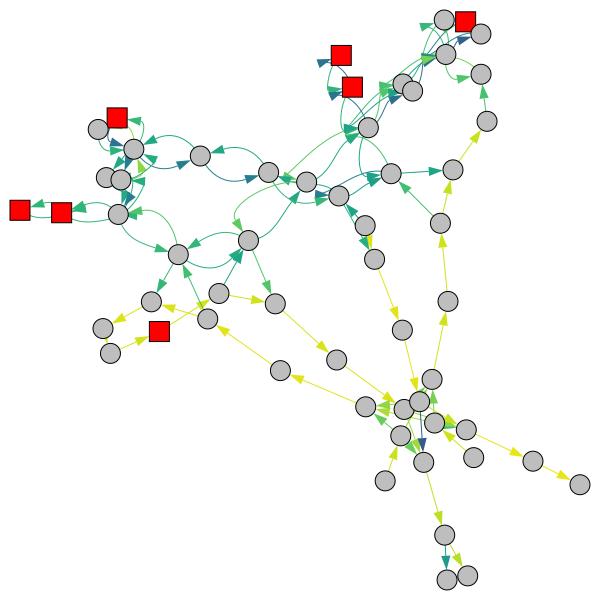

In [11]:
random.seed(1234) # for example reproducibility
sg = g.subgraph(g.neighborhood(1, order= 7))

sg_df = sg.get_edge_dataframe()

# here's what the subgraph looks like. The edges are colored by volume of traffic.
ig.plot(sg)

We can asume bike riders move randomly in the network and thus generate fake commuter data: 

In [12]:
# %% generate some fake commuter data:
paths = []
time = []
volume = []
for v in sg.vs.indices:
    
    path = random.sample(filter_subpaths(sg.get_all_shortest_paths(v)), 1)[0]
    if len(path) >1:
        paths.append(path)
        time.append(calculate_travel_time(path, sg_df))
        volume.append(get_total_volume(path, sg_df))

riders = pd.DataFrame({"path":paths, "travel_time":time, "weight": volume})

print(riders.shape)
print(riders.head())


(54, 3)
                                 path  travel_time        weight
0    [0, 1, 35, 36, 21, 10, 8, 9, 53]     9.117342  20571.200000
1     [1, 35, 34, 33, 32, 31, 29, 28]     3.227798  43173.715849
2  [2, 13, 11, 12, 55, 36, 21, 10, 8]     8.585493   9076.300000
3               [3, 4, 12, 11, 13, 2]     7.596273   4749.300000
4       [4, 12, 55, 36, 21, 10, 6, 5]    12.840152   7598.800000


In [13]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   path         54 non-null     object 
 1   travel_time  54 non-null     float64
 2   weight       54 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.4+ KB


In [21]:
# We merge trips data to our current subgraph:

anaheim_trips = anaheim_trips.astype({"Origin":"int","Destination":"int", "Weight":"float"})
anaheim_trips = anaheim_trips.astype({"Weight":"int"})
anaheim_trips.head()

real_riders_merged = pd.merge(anaheim_trips, trip_paths_simple, on=['Origin', 'Destination'])
# g_df = g.get_edge_dataframe()

real_riders_merged["travel_time"]= real_riders_merged['path'].apply(calculate_travel_time, args=(sg_df,))
# because we are using the subgraph, there will be travel times == 0 (not in the subplot)
# we filter them out. when using the whole graph, the data is fully computed
riders = real_riders_merged[real_riders_merged["travel_time"]!=0]
riders["travel_time_weighted"]=riders["travel_time"]*riders["Weight"]

C:\Users\danid\AppData\Local\Temp\ipykernel_19292\377648109.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riders["travel_time_weighted"]=riders["travel_time"]*riders["Weight"]


CAREFUL: nan values are being generated by the function below. Needs checking...

We can calculate travel times for each path, and considering

In [76]:
 # %% calculate new travel time based on this
travel_time_bike = []
for i, path in enumerate(riders.path):
    if any_subpath(station_paths, path):
        travel_time_bike.append(calculate_travel_time_bike(path, sg_df, is_bike_edge)*riders["Weight"].iloc[i])
    else:
        travel_time_bike.append(riders['travel_time_weighted'].iloc[i])
riders['travel_time_bike'] = pd.Series(travel_time_bike)


print('travel time without stations: ', riders.travel_time_weighted.sum())
print('travel time with two randomly placed stations: ', riders.travel_time_bike.sum())


KeyError: 'travel_time_weighted'